# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

**Desciption:** This projects aims to create a lane detector for given video inputs.  
The pipeline is given below.

## Build a Lane Finding Pipeline

### Importing Required Packages

1. Converting RGB frames into HSV
2. Smoothing the frames to suppress noise
3. Canny transformation to detect lanes
4. Identifying masked regions
5. Hough transformation to draw lines in images
6. Draw line on the original image

In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

### Reading Test Images

In [4]:
test_images = sorted(os.listdir("test_images/"))
test_images

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

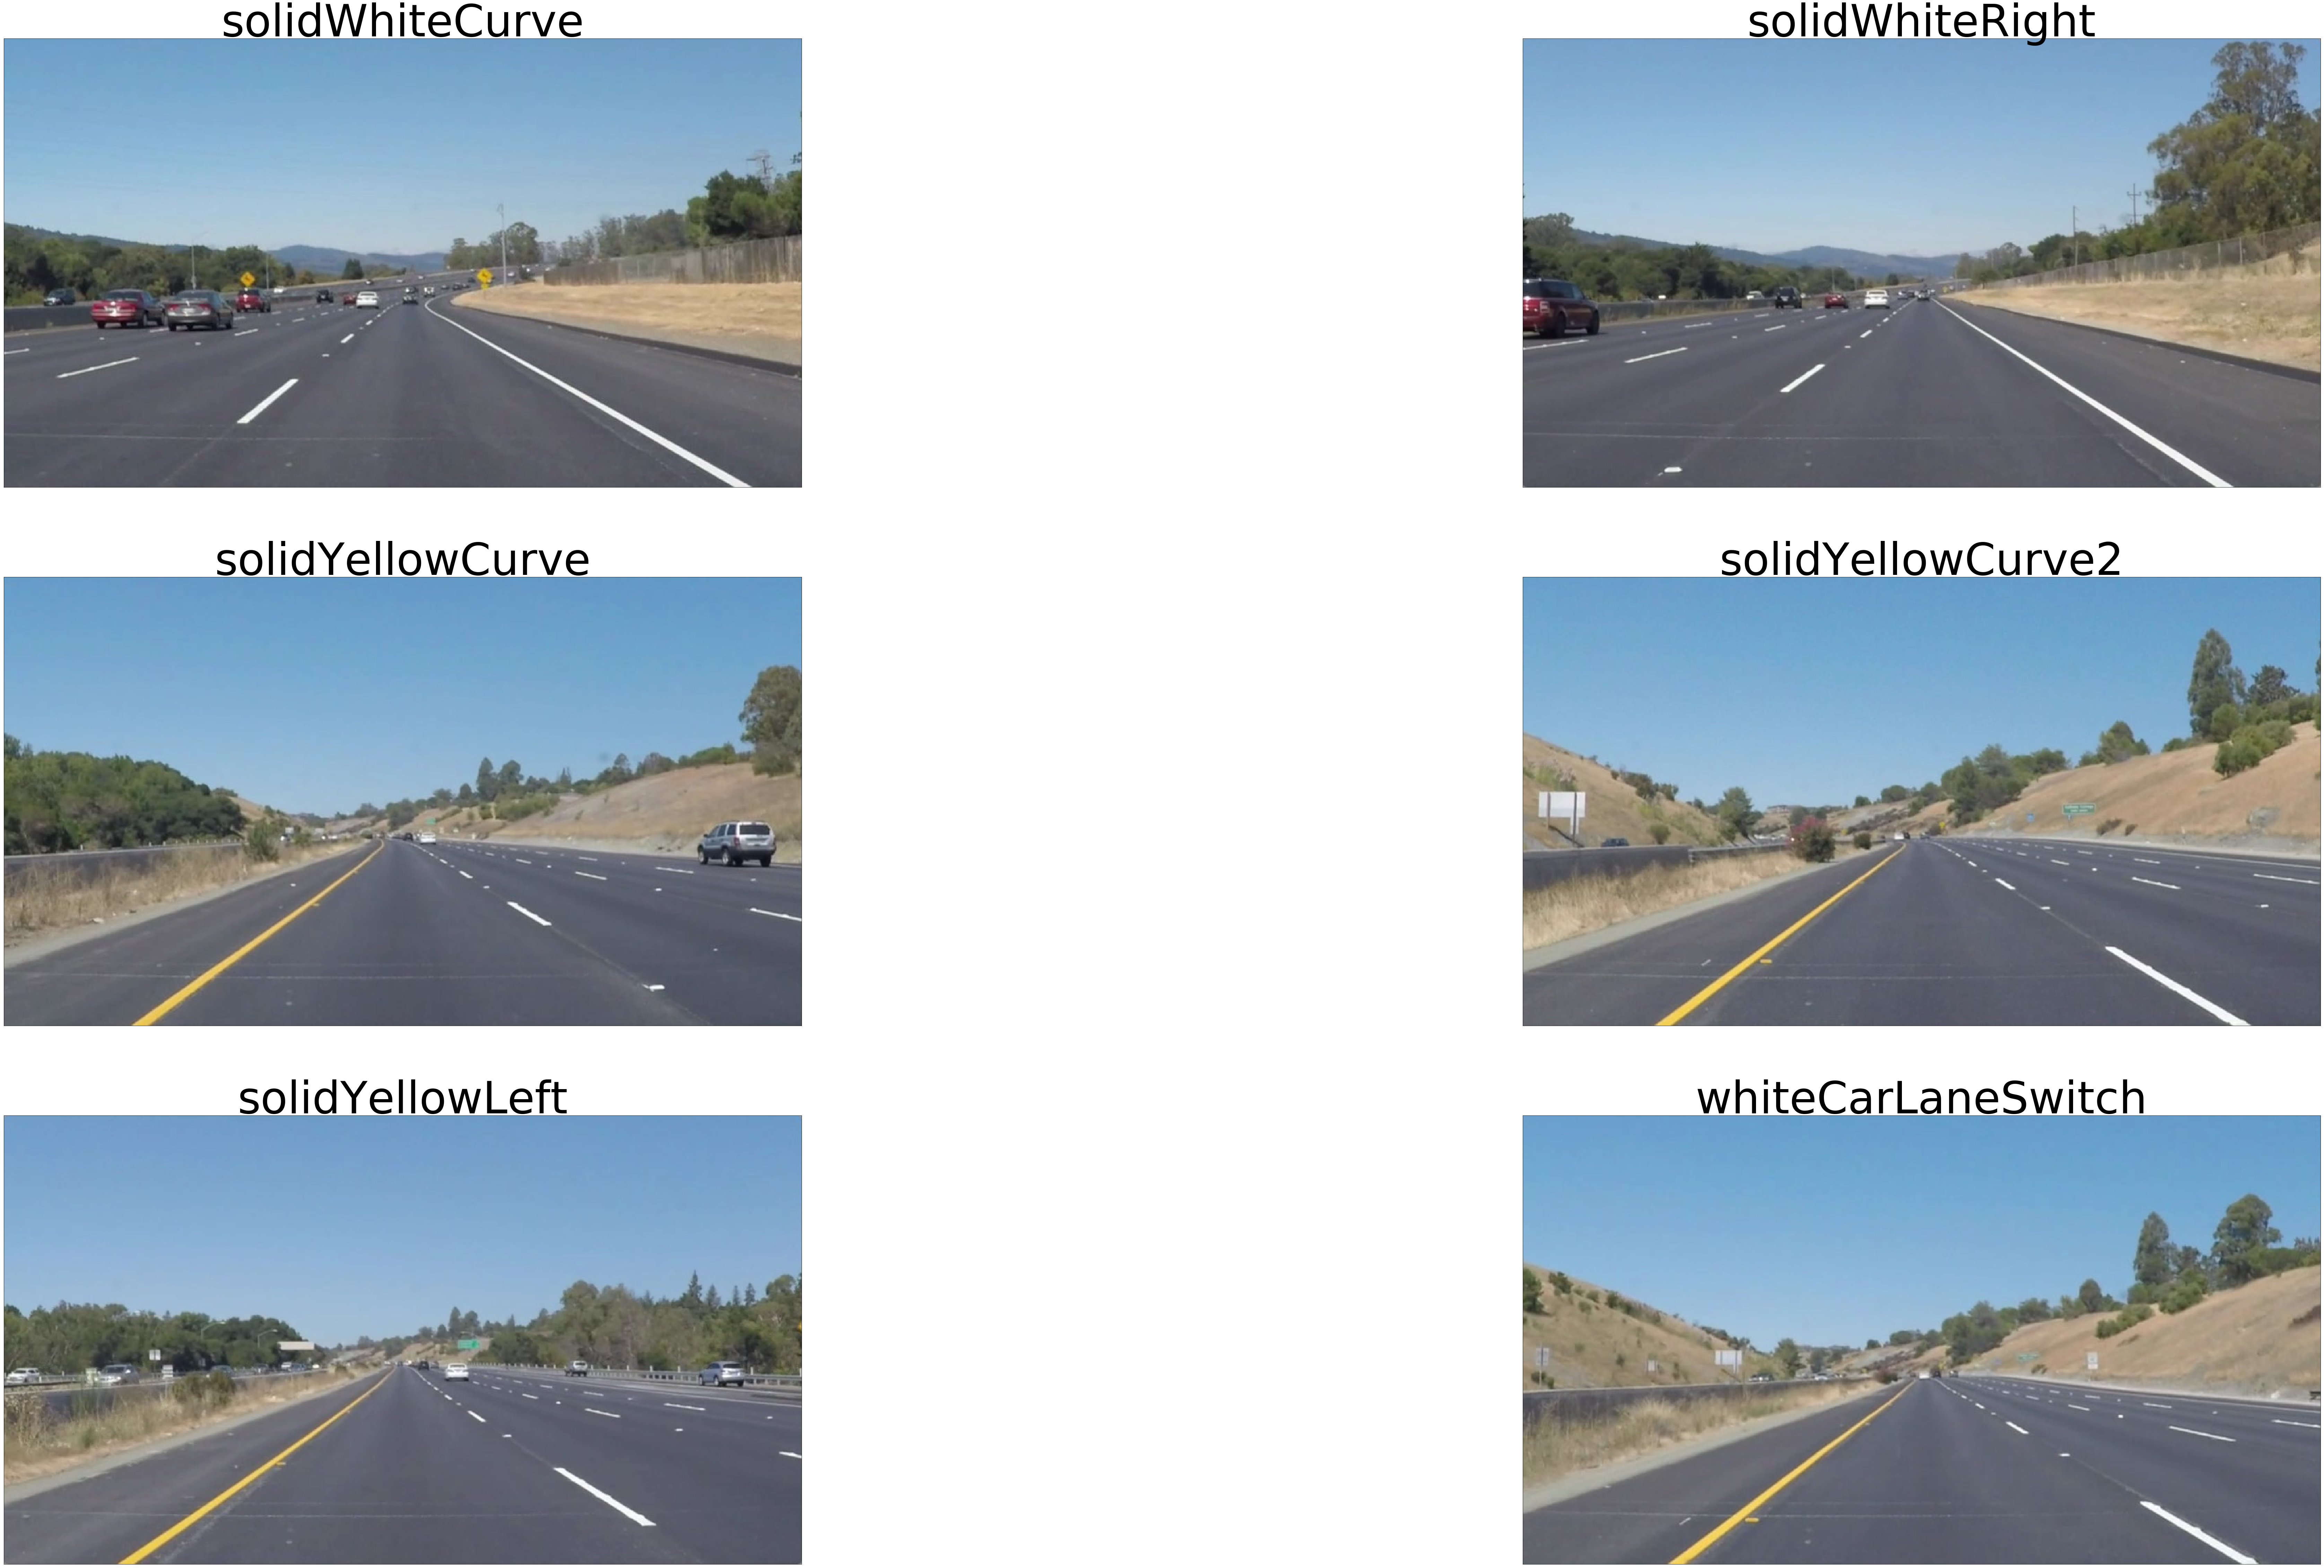

CPU times: user 26.2 s, sys: 297 ms, total: 26.5 s
Wall time: 26.8 s


In [5]:
#Reading test images
img1 = mpimg.imread("test_images/"+test_images[0])  #solidWhiteCurve
img2 = mpimg.imread("test_images/"+test_images[1])  #solidWhiteRight
img3 = mpimg.imread("test_images/"+test_images[2])  #solidYellowCurve
img4 = mpimg.imread("test_images/"+test_images[3])  #solidYellowCurve2
img5 = mpimg.imread("test_images/"+test_images[4])  #solidYellowLeft
img6 = mpimg.imread("test_images/"+test_images[5])  #whiteCarLaneSwitch

#Plotting test images
plt.figure(figsize=(144,81))
plt.subplot(321), plt.imshow(img1)
plt.title(test_images[0][:-4], fontdict={'fontsize':128}), plt.xticks([]), plt.yticks([])
plt.subplot(322), plt.imshow(img2)
plt.title(test_images[1][:-4], fontdict={'fontsize':128}), plt.xticks([]), plt.yticks([])
plt.subplot(323), plt.imshow(img3)
plt.title(test_images[2][:-4], fontdict={'fontsize':128}), plt.xticks([]), plt.yticks([])
plt.subplot(324), plt.imshow(img4)
plt.title(test_images[3][:-4], fontdict={'fontsize':128}), plt.xticks([]), plt.yticks([])
plt.subplot(325), plt.imshow(img5)
plt.title(test_images[4][:-4], fontdict={'fontsize':128}), plt.xticks([]), plt.yticks([])
plt.subplot(326), plt.imshow(img6)
plt.title(test_images[5][:-4], fontdict={'fontsize':128}), plt.xticks([]), plt.yticks([])
%time plt.show()

## LaneDetection

**OpenCV functions used in this project:**

`cv2.cvtColor()`     To converts RGB image to HSV  
`cv2.inRange()`      For color selection  
`cv2.bitwise_and()`  To apply a mask to an image  
`cv2.fillPoly()`     To determine region of interest in the image  
`cv2.HoughLinesP()`  To move from the picture space to the HOUGH space  
`cv2.GaussianBlur()` To smooth image for removing noise  
`cv2.Canny()`        For Canny Edge Detection  
`cv2.line()`         To draw lines on an image given endpoints  
`cv2.addWeighted()`  To coadd / overlay two images  
`cv2.imwrite()`      To output images to file  

The LaneDetection class is given below.  
For the sake of simplicity, all related functions and parameters for lane detection are gathered under 'LaneDetection' class.

In [10]:
class LaneDetection:
    '''
    This is a tool for lane detection for given images.
    The entire class contains parameters for required operations and functions.
    To use this tool, use get_output(self,img) function inside this class.
    '''
    def __init__(self,
                 buffer_size=10,
                 kernel_size=3,
                 canny_low_th=25,
                 canny_high_th=75,
                 hough_rho=2,
                 hough_theta=(np.pi/180),
                 hough_th=50,
                 hough_min_line_len=15,
                 hough_max_line_gap=7.5,
                 min_line_slope=0.5,
                 max_line_slope=1,
                 line_color=[255, 0, 0]):
        self.buffer_size = buffer_size
        self.kernel_size = kernel_size
        self.canny_low_th = canny_low_th
        self.canny_high_th = canny_high_th
        self.hough_rho = hough_rho
        self.hough_theta = hough_theta
        self.hough_th = hough_th
        self.hough_min_line_len = hough_min_line_len
        self.hough_max_line_gap = hough_max_line_gap
        self.min_line_slope = min_line_slope
        self.max_line_slope = max_line_slope
        self.line_color = line_color
        self.left_buffer = []
        self.right_buffer = []

    def rgb2hsv(self, img):
        '''
        Converts RGB image to HSV (Hue, Saturation, Value) space
        and eliminates colors that are out of our interest.
        '''
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        
        white_dark = np.array([0, 0, 200], dtype=np.uint8)
        white_light = np.array([255, 30, 255], dtype=np.uint8)
        range_white = cv2.inRange(img, white_dark, white_light)
        
        yellow_dark = np.array([15, 127, 127], dtype=np.uint8)
        yellow_light = np.array([30, 255, 255], dtype=np.uint8)
        range_yellow = cv2.inRange(img, yellow_dark, yellow_light)

        return cv2.bitwise_and(img, img, mask=(range_yellow | range_white))

    def img_mask(self, img):
        '''
        Preserves only the region of the image defined by the polygon
        created from "vertices".
        Places outside this region are turned black.
        '''
        rows = img.shape[0]
        cols = img.shape[1]
        top = int(rows/2 + 50)
        vertices = np.array([[(      30, rows),
                              (     450,  top),
                              (cols-450,  top),
                              ( cols-30, rows)]], dtype=int)
        mask = np.zeros_like(img)
        cv2.fillPoly(mask, vertices, 255)
        return img & mask

    def line_to_buffer(self, line, buffer):
        '''
        Preserves the newest lines based on given buffer size
        '''
        
        buffer.append(line)
        return buffer[-self.buffer_size:]

    def line_segmentation(self, x1, x2, line):
        '''
        Return y1 & y2 values for given x1 and x2
        '''
        polynom = np.poly1d(line)
        y1, y2 = int(polynom(x1)), int(polynom(x2))
        return ((x1,y1), (x2,y2))
    
    def line_intersection(self, left_line, right_line):
        """
        Returns the intersection of the lines
        """
        left_slope, left_intercept = left_line
        right_slope, right_intercept = right_line
        
        #put the coordinates into homogeneous form
        a = [[left_slope, -1],
             [right_slope, -1]]
        b = [-left_intercept, -right_intercept]
        x, y = np.linalg.solve(a, b)
        return int(x)
    
    def line_positioning(self, line_segments, mid_x):
        '''
        Determines where the line belongs based on it's position in the image.
        '''
        points_left = {'X': [], 'Y': [],}
        points_right = {'X': [], 'Y': [],}
        for segment in line_segments:
            x1, y1, x2, y2 = segment[0]
            diff_Y = y2 - y1
            diff_X = x2 - x1
            if diff_X != 0:
                slope = float(diff_Y) / float(diff_X)
                if x1 < mid_x and x2 < mid_x: # left lines
                    if -self.max_line_slope < slope < -self.min_line_slope:
                        points_left['X'] += [x1,x2]
                        points_left['Y'] += [y1,y2]
                elif x1 > mid_x and x2 > mid_x: # right lines
                    if self.max_line_slope > slope > self.min_line_slope:
                        points_right['X'] += [x1,x2]
                        points_right['Y'] += [y1,y2]
        return points_left, points_right
    
    def line_fitting(self, points_left, points_right):
        """
        Fits a line to each of the point sets and adds to the buffer to return
        the average slope and y-intercept values on the last N frames
        """
        if len(points_left['X']) > 1:
            left_line = np.polyfit(points_left['X'], points_left['Y'], 1)
            self.left_buffer = self.line_to_buffer(left_line, self.left_buffer)
        if len(points_right['X']) > 1:
            right_line = np.polyfit(points_right['X'], points_right['Y'], 1)
            self.right_buffer = self.line_to_buffer(right_line, self.right_buffer)
        
        return (np.mean(self.left_buffer, axis=0),
                np.mean(self.right_buffer, axis=0),)

    def hough_lines(self, img):
        left_x = 0
        right_x = img.shape[1]
        line_segments = cv2.HoughLinesP(img, self.hough_rho, self.hough_theta, self.hough_th,
                                        minLineLength=self.hough_min_line_len,
                                        maxLineGap=self.hough_max_line_gap)
        points_left, points_right = self.line_positioning(line_segments, int(right_x / 2))
        left_line, right_line = self.line_fitting(points_left, points_right)
        intersection_x = self.line_intersection(left_line, right_line)

        return (self.line_segmentation(left_x, intersection_x, left_line),
                self.line_segmentation(right_x, intersection_x, right_line),)
    
    def blur_and_canny(self, img):
        filtered_img = self.rgb2hsv(img)
        filtered_img = cv2.GaussianBlur(filtered_img[:,:,2], (self.kernel_size, self.kernel_size), 0)
        filtered_img = cv2.Canny(filtered_img, self.canny_low_th, self.canny_high_th)
        return self.img_mask(filtered_img)
    
    def process_image(self, img):
        filtered_img = self.blur_and_canny(img)
        lane_lines = self.hough_lines(filtered_img)
        line_img = np.zeros_like(img)
        for line in lane_lines:
            cv2.line(line_img, line[0], line[1], self.line_color, 5)
        return cv2.addWeighted(img, 1., line_img, 1., 0.)

Build the pipeline and run your solution on all test_images.  
Make copies into the `test_images_output` directory, and you can use the images in your writeup report.  

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.  

In [11]:
#Calling the class in short
ld = LaneDetection()

### Testing rgb2hsv & roi performance

In [13]:
#Testing rgb2hsv & mask
num_of_img = 1
test_output1a, test_output1b  = ld.rgb2hsv(img1), ld.img_mask(img1)

#Plotting
plt.figure(figsize=(288,162))
plt.subplot(121), plt.imshow(test_output1a)
title1a = "RGB to HSV" + " (" + test_images[num_of_img-1][:-4] + ")"
plt.title(title1a, fontdict={'fontsize':256}), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(test_output1b)
title1b = "Region of Interest" + " (" + test_images[num_of_img-1][:-4] + ")"
plt.title(title1b, fontdict={'fontsize':256}), plt.xticks([]), plt.yticks([])
%time plt.show()

CPU times: user 1min 19s, sys: 1.15 s, total: 1min 21s
Wall time: 1min 21s


### Testing the final output (on test images)

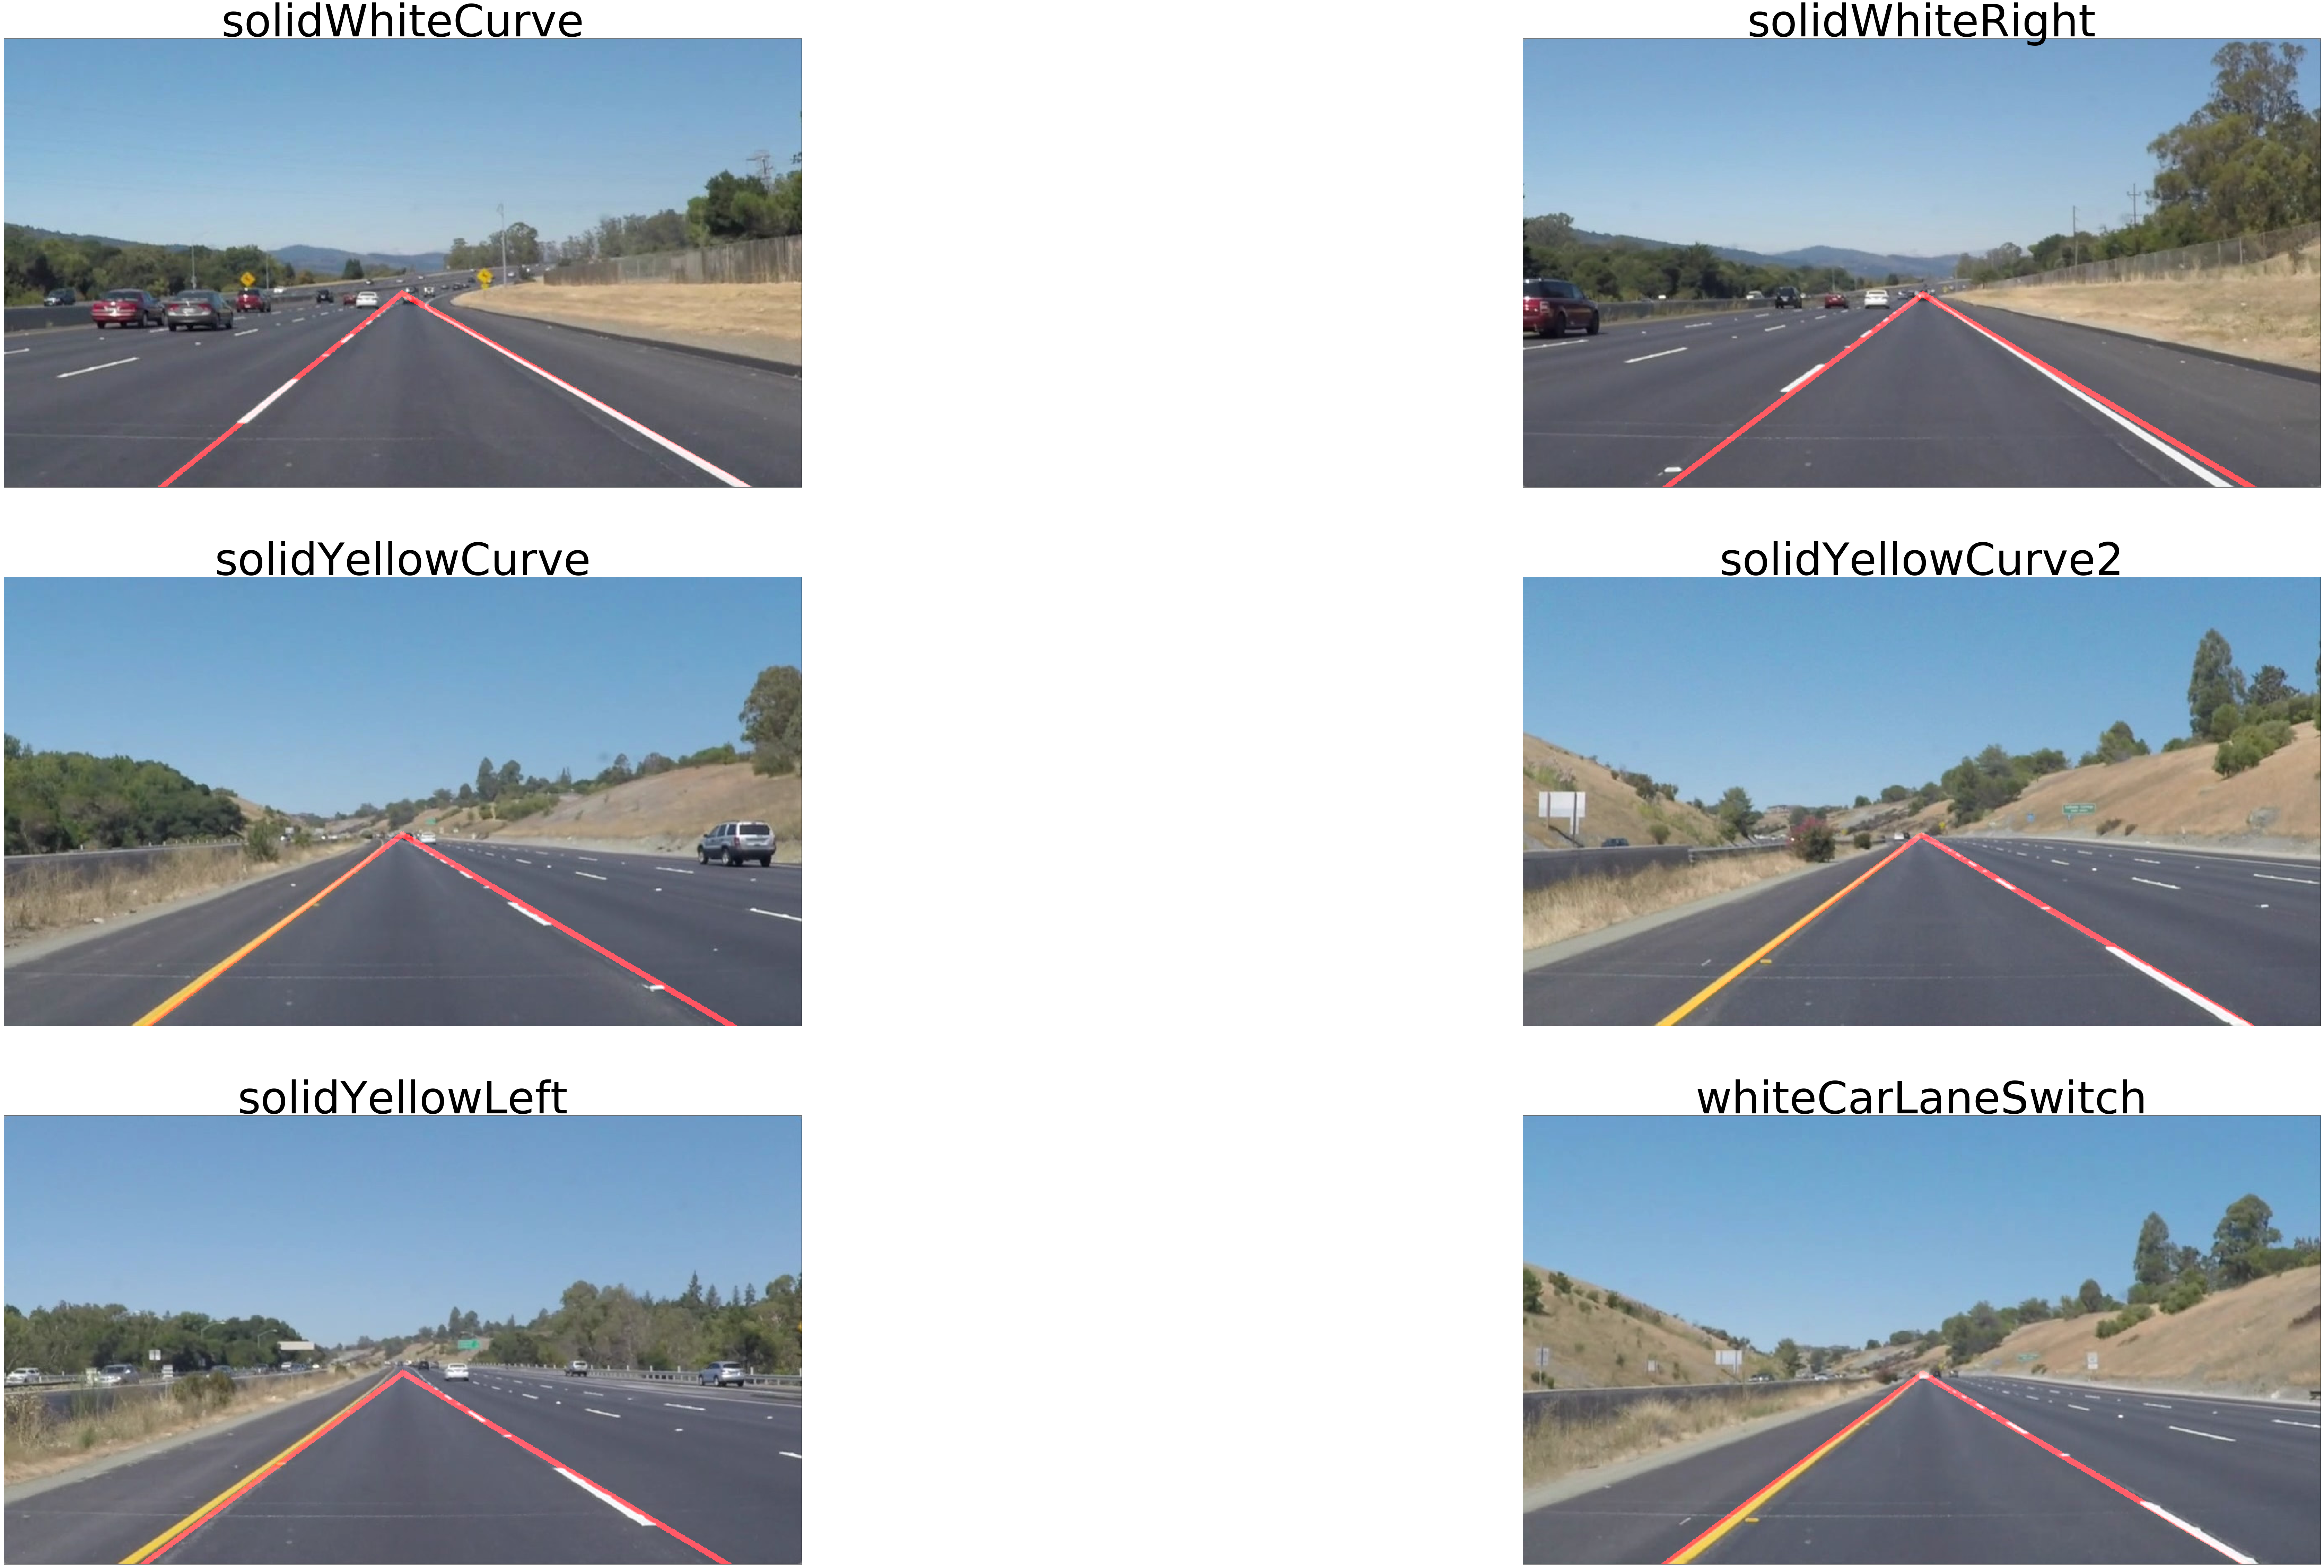

CPU times: user 26.2 s, sys: 200 ms, total: 26.4 s
Wall time: 26.5 s


In [14]:
#Testing the final output
output1 = ld.process_image(mpimg.imread("test_images/"+test_images[0]))
output2 = mpimg.imread("test_images/"+test_images[1])
output3 = mpimg.imread("test_images/"+test_images[2])
output4 = mpimg.imread("test_images/"+test_images[3])
output5 = mpimg.imread("test_images/"+test_images[4])
output6 = mpimg.imread("test_images/"+test_images[5])

#Plotting test images
plt.figure(figsize=(144,81))
plt.subplot(321), plt.imshow(ld.process_image(mpimg.imread("test_images/"+test_images[0])))
plt.title(test_images[0][:-4], fontdict={'fontsize':128}), plt.xticks([]), plt.yticks([])

plt.subplot(322), plt.imshow(ld.process_image(mpimg.imread("test_images/"+test_images[1])))
plt.title(test_images[1][:-4], fontdict={'fontsize':128}), plt.xticks([]), plt.yticks([])

plt.subplot(323), plt.imshow(ld.process_image(mpimg.imread("test_images/"+test_images[2])))
plt.title(test_images[2][:-4], fontdict={'fontsize':128}), plt.xticks([]), plt.yticks([])

plt.subplot(324), plt.imshow(ld.process_image(mpimg.imread("test_images/"+test_images[3])))
plt.title(test_images[3][:-4], fontdict={'fontsize':128}), plt.xticks([]), plt.yticks([])

plt.subplot(325), plt.imshow(ld.process_image(mpimg.imread("test_images/"+test_images[4])))
plt.title(test_images[4][:-4], fontdict={'fontsize':128}), plt.xticks([]), plt.yticks([])

plt.subplot(326), plt.imshow(ld.process_image(mpimg.imread("test_images/"+test_images[5])))
plt.title(test_images[5][:-4], fontdict={'fontsize':128}), plt.xticks([]), plt.yticks([])

%time plt.show()

## Test on Videos

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [ ]:
## Exporting frames from the videos
video_swr = cv2.VideoCapture("test_videos/solidWhiteRight.mp4")
video_syl = cv2.VideoCapture("test_videos/solidYellowLeft.mp4")

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [ ]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
white_output = "test_videos_output/white.mp4"
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
white_clip = clip1.fl_image(ld.process_image) #NOTE: this function expects color images!!

In [25]:
%time white_clip.write_videofile(white_output, audio=False, codec='mpeg4', preset='medium')

[MoviePy] >>>> Building video test_videos_output/white.mp4
[MoviePy] Writing video test_videos_output/white.mp4


 99%|█████████▉| 125/126 [00:04<00:00, 30.83it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/white.mp4 

CPU times: user 2.5 s, sys: 143 ms, total: 2.64 s
Wall time: 4.09 s


## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [19]:
yellow_output = 'test_videos_output/yellow.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(ld.process_image)

In [20]:
%time yellow_clip.write_videofile(yellow_output, audio=False, codec='mpeg4', preset='medium')

[MoviePy] >>>> Building video test_videos_output/yellow.mp4
[MoviePy] Writing video test_videos_output/yellow.mp4


100%|█████████▉| 681/682 [00:18<00:00, 36.49it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/yellow.mp4 

CPU times: user 11.6 s, sys: 451 ms, total: 12 s
Wall time: 18.7 s


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [23]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(ld.process_image)

In [24]:
%time challenge_clip.write_videofile(challenge_output, audio=False, codec='mpeg4', preset='medium')

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:13<00:00, 19.04it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 7.22 s, sys: 359 ms, total: 7.58 s
Wall time: 13.2 s


In [ ]:
#END OF THE NOTEBOOK#